## Naive Bayes Classifier

In [ ]:
# Naive Bayes Classifier in R
# This script demonstrates the use of Naive Bayes algorithm for supervised learning.
# Naive Bayes is a probabilistic classifier based on Bayes' Theorem with strong (naive) independence assumptions.
# We'll use the 'e1071' package, which provides the Naive Bayes implementation in R.
# The workflow includes loading data, preprocessing, training the model, making predictions, and evaluating performance.

# First, we install the packages and load the necessary libraries
install.packages("dplyr")
install.packages("gridExtra")
install.packages("caret")
install.packages("GGally")
library(ggplot2)
library(dplyr)
library(gridExtra)
library(caret)
library(e1071)
library(reshape2)
library(GGally)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘proxy’, ‘iterators’, ‘Rcpp’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘timeDate’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘labelled’, ‘broom.helpers’, ‘patchwork’, ‘ggstats’



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘gridExtra’


The following object

## 1. Load, Visualization, and Preparation

In [ ]:
# Load the data
# We will be using the adult.csv dataset, which can be found on Kaggle (https://www.kaggle.com/datasets/wenruliu/adult-income-dataset)
# We will try to predict a qualitative outcome, in this case, the income class, which is divided into <=50K and >50K, based on a series of inputs.

file_path <- "adult.csv"
data <- read.csv(file_path)

# a) Describe the data and verify that the identified types: 'int' or 'chr' are correct in each case
str(data)

# b) Identify if there are any '?' values and replace them with NaN
data[data == "?"] <- NA

# c) Identify if there are any NaN values. We see that there are several.
null_counts <- sapply(data, function(x) sum(is.na(x)))
null_counts

# Provide a summary to see interesting metrics in general
summary(data)

'data.frame':	48842 obs. of  15 variables:
 $ age            : int  25 38 28 44 18 34 29 63 24 55 ...
 $ workclass      : chr  "Private" "Private" "Local-gov" "Private" ...
 $ fnlwgt         : int  226802 89814 336951 160323 103497 198693 227026 104626 369667 104996 ...
 $ education      : chr  "11th" "HS-grad" "Assoc-acdm" "Some-college" ...
 $ educational.num: int  7 9 12 10 10 6 9 15 10 4 ...
 $ marital.status : chr  "Never-married" "Married-civ-spouse" "Married-civ-spouse" "Married-civ-spouse" ...
 $ occupation     : chr  "Machine-op-inspct" "Farming-fishing" "Protective-serv" "Machine-op-inspct" ...
 $ relationship   : chr  "Own-child" "Husband" "Husband" "Husband" ...
 $ race           : chr  "Black" "White" "White" "Black" ...
 $ gender         : chr  "Male" "Male" "Male" "Male" ...
 $ capital.gain   : int  0 0 0 7688 0 0 0 3103 0 0 ...
 $ capital.loss   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ hours.per.week : int  40 50 40 40 30 30 40 32 40 10 ...
 $ native.country : chr  "United-Sta

age       workclass          fnlwgt       education educational.num 
              0            2799               0               0               0 
 marital.status      occupation    relationship            race          gender 
              0            2809               0               0               0 
   capital.gain    capital.loss  hours.per.week  native.country          income 
              0               0               0             857               0

      age         workclass             fnlwgt         education        
 Min.   :17.00   Length:48842       Min.   :  12285   Length:48842      
 1st Qu.:28.00   Class :character   1st Qu.: 117550   Class :character  
 Median :37.00   Mode  :character   Median : 178144   Mode  :character  
 Mean   :38.64                      Mean   : 189664                     
 3rd Qu.:48.00                      3rd Qu.: 237642                     
 Max.   :90.00                      Max.   :1490400                     
 educational.num marital.status      occupation        relationship      
 Min.   : 1.00   Length:48842       Length:48842       Length:48842      
 1st Qu.: 9.00   Class :character   Class :character   Class :character  
 Median :10.00   Mode  :character   Mode  :character   Mode  :character  
 Mean   :10.08                                                           
 3rd Qu.:12.00                                                           
 Max.   :16.00                               

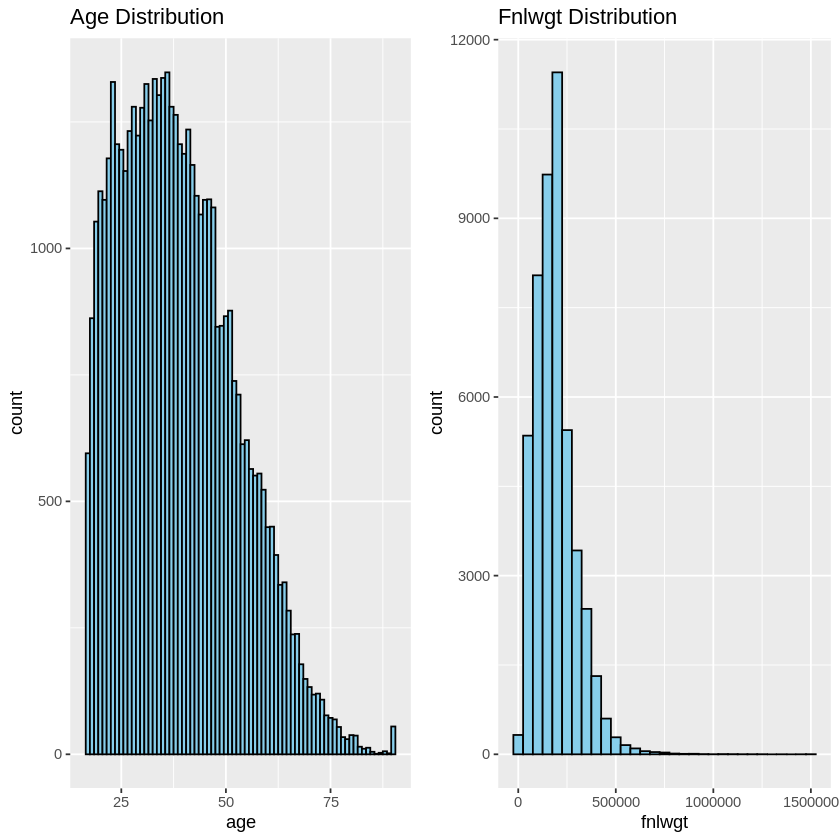

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.”


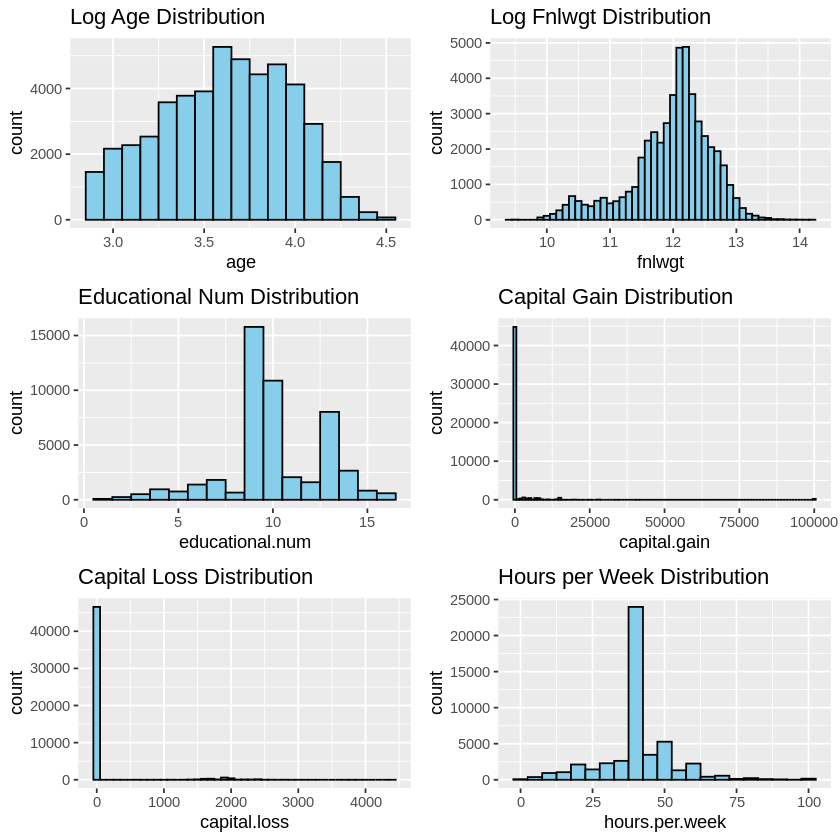

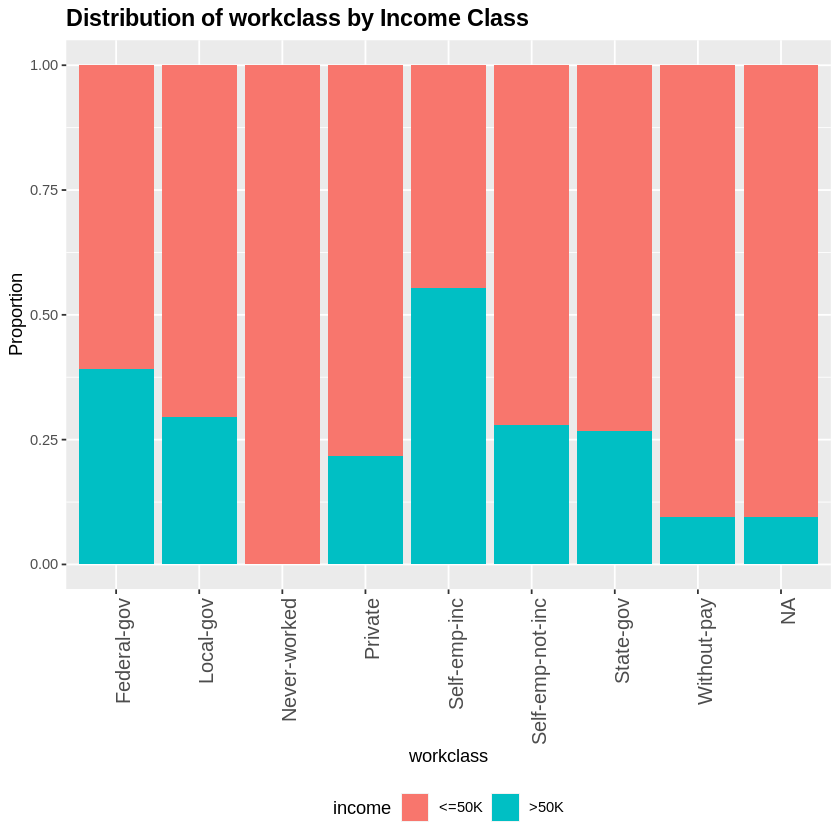

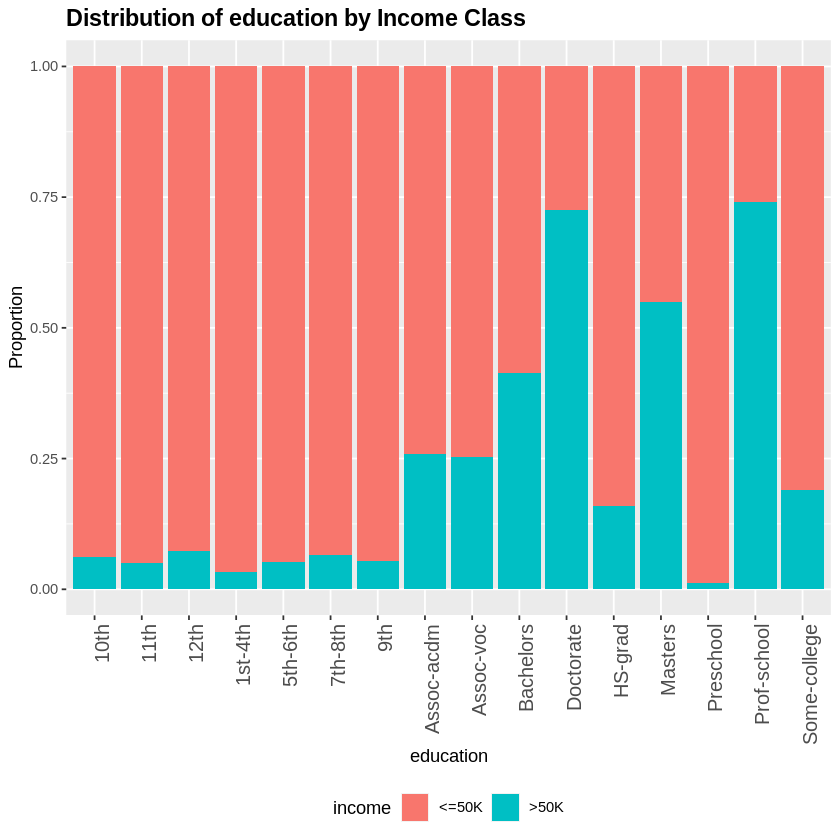

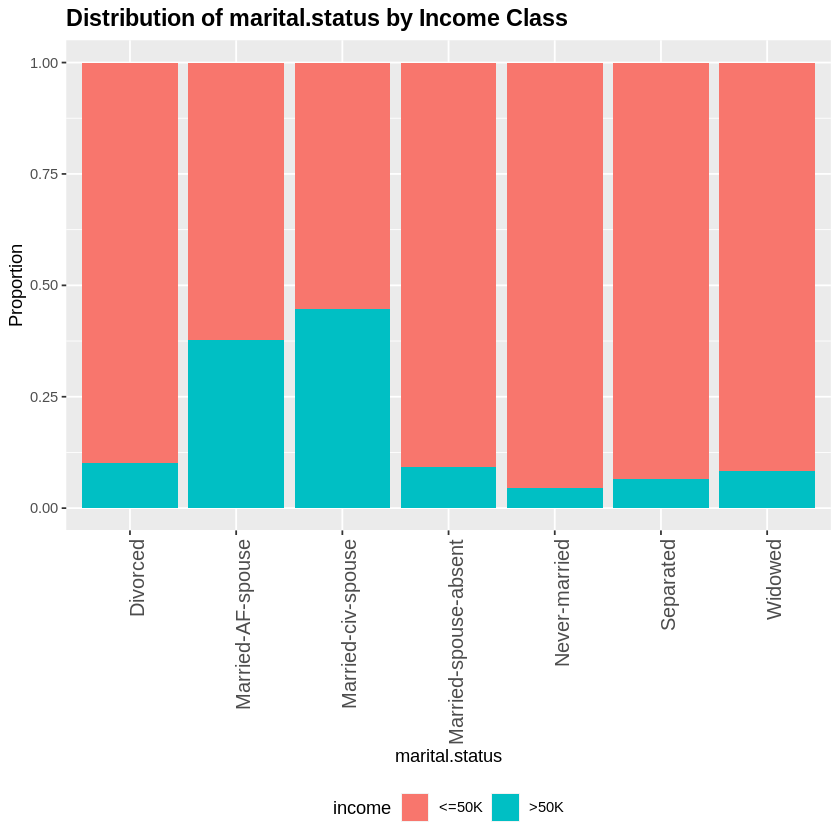

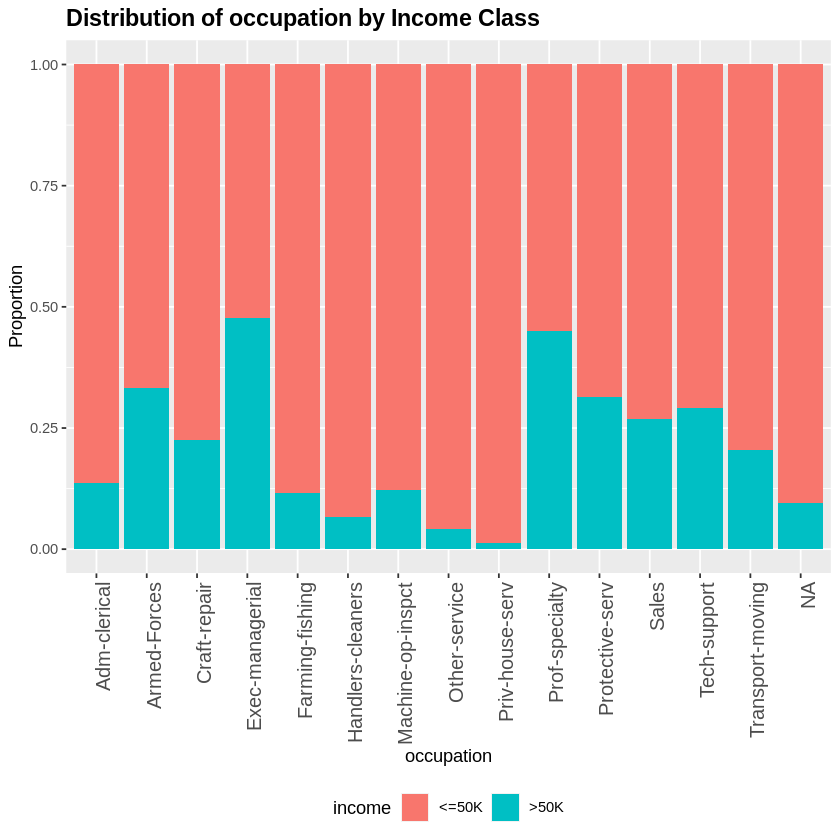

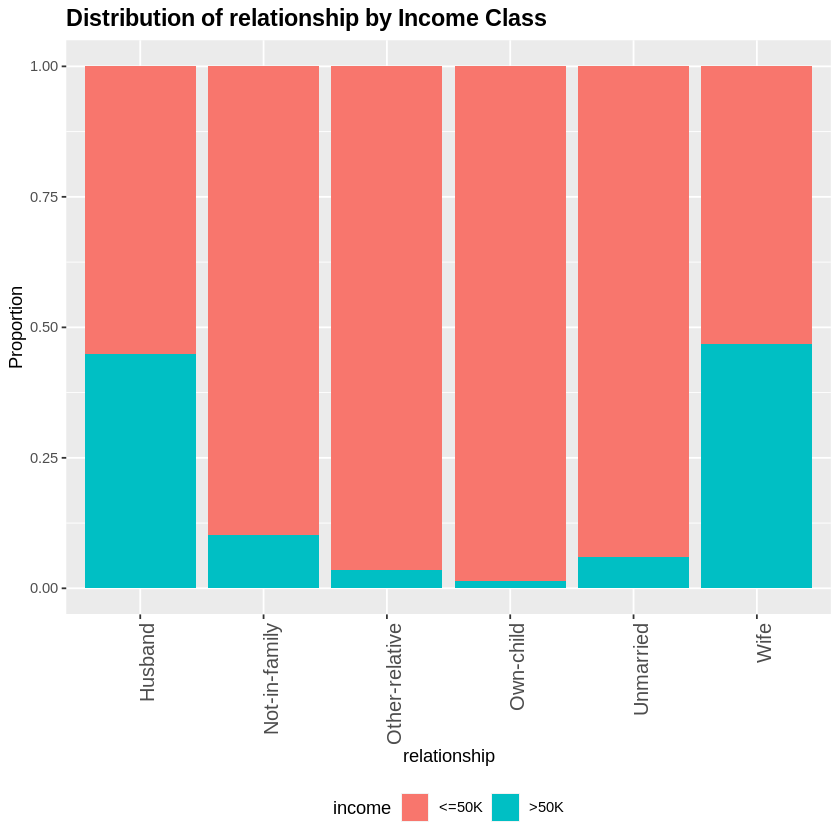

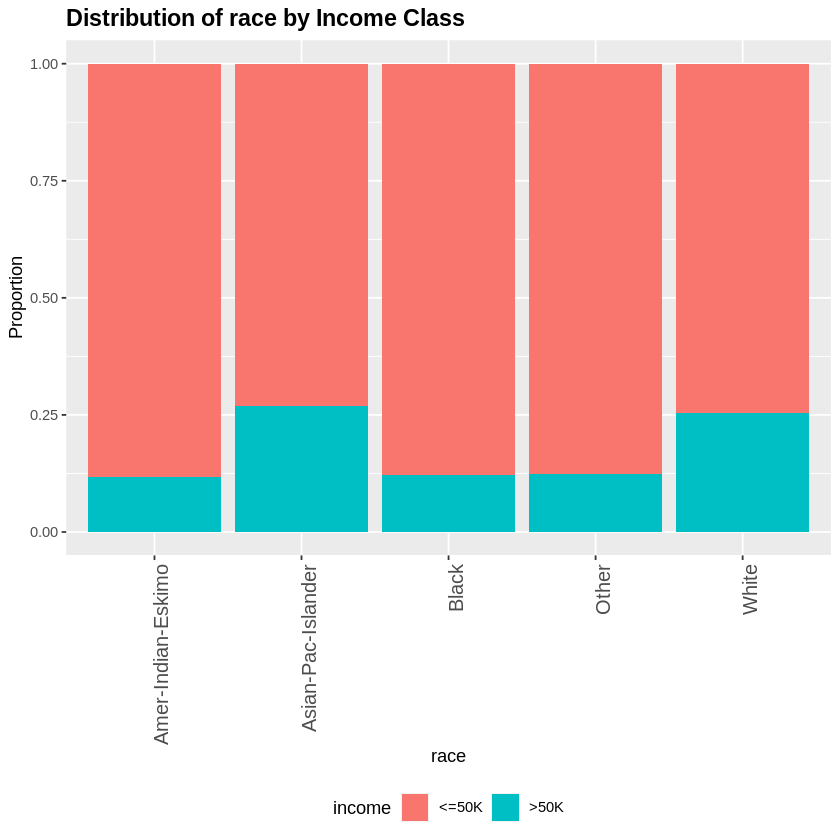

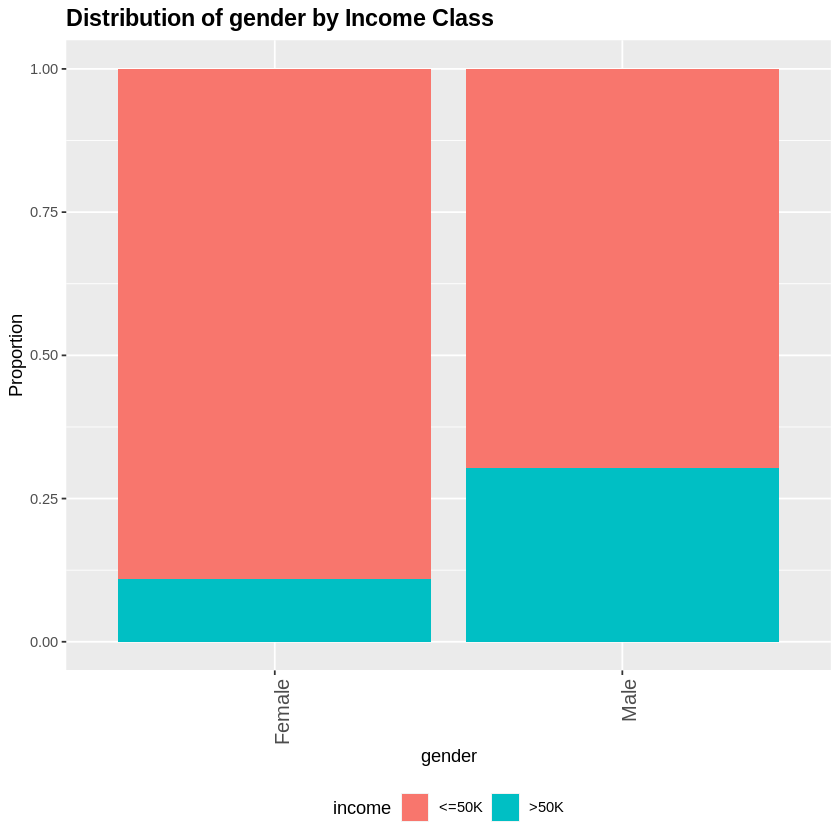

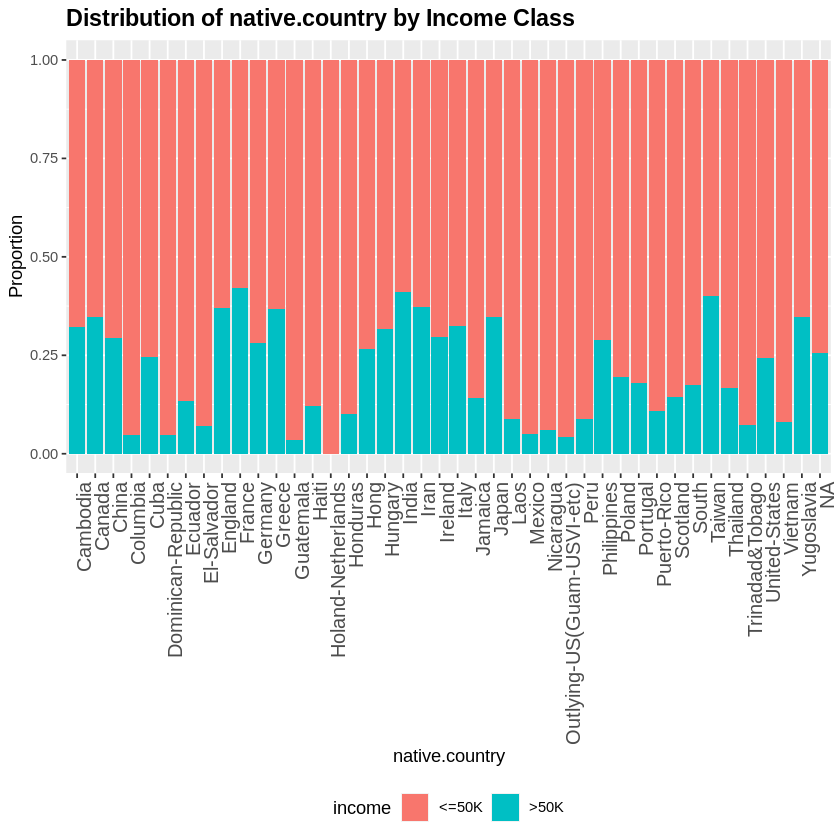

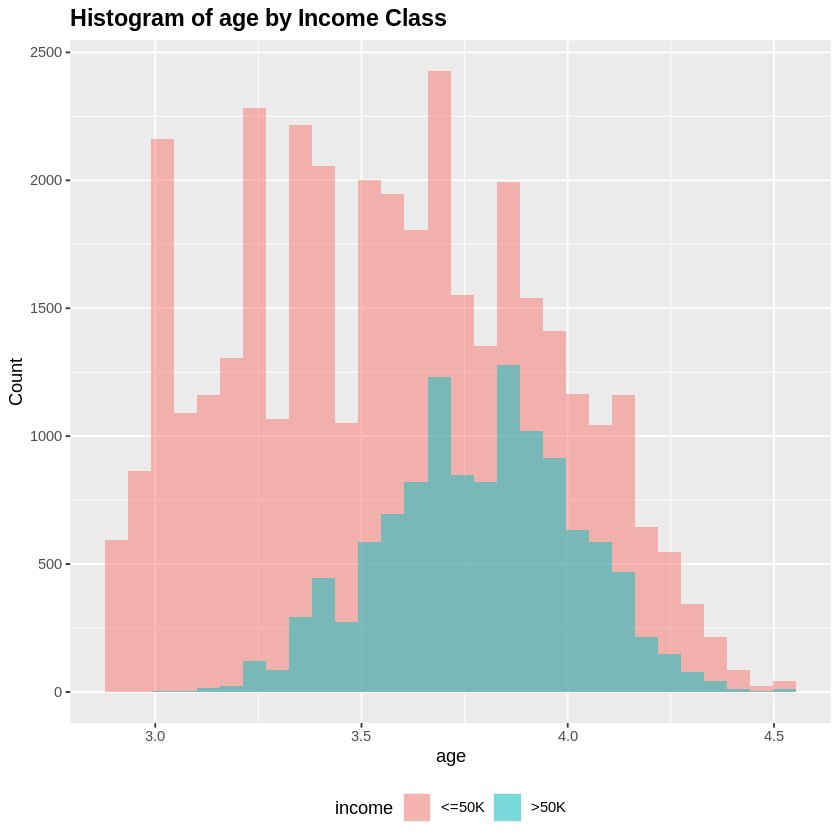

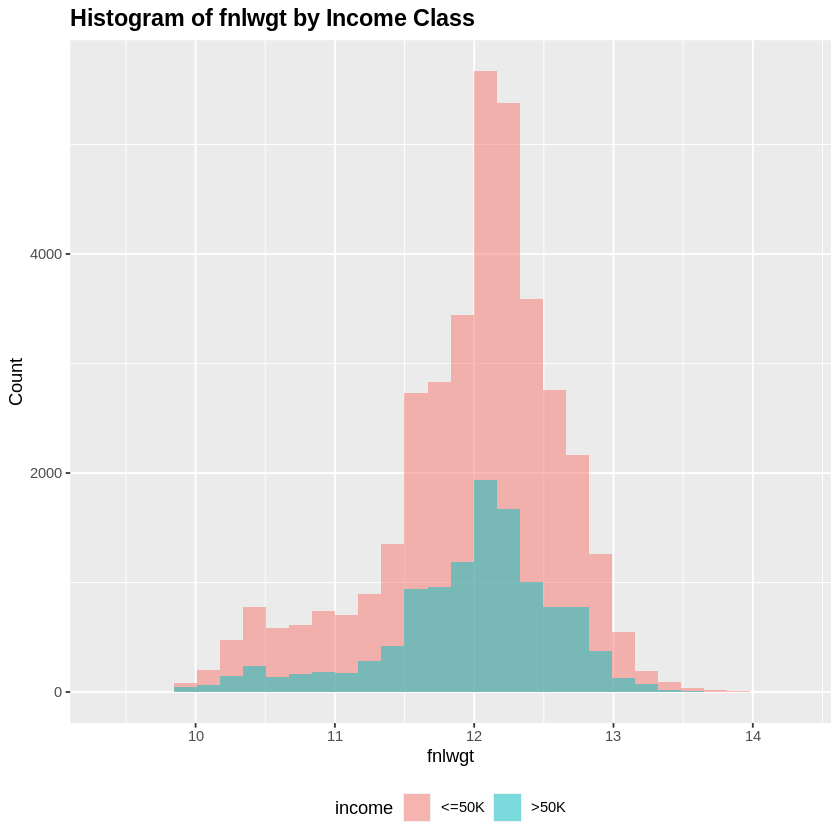

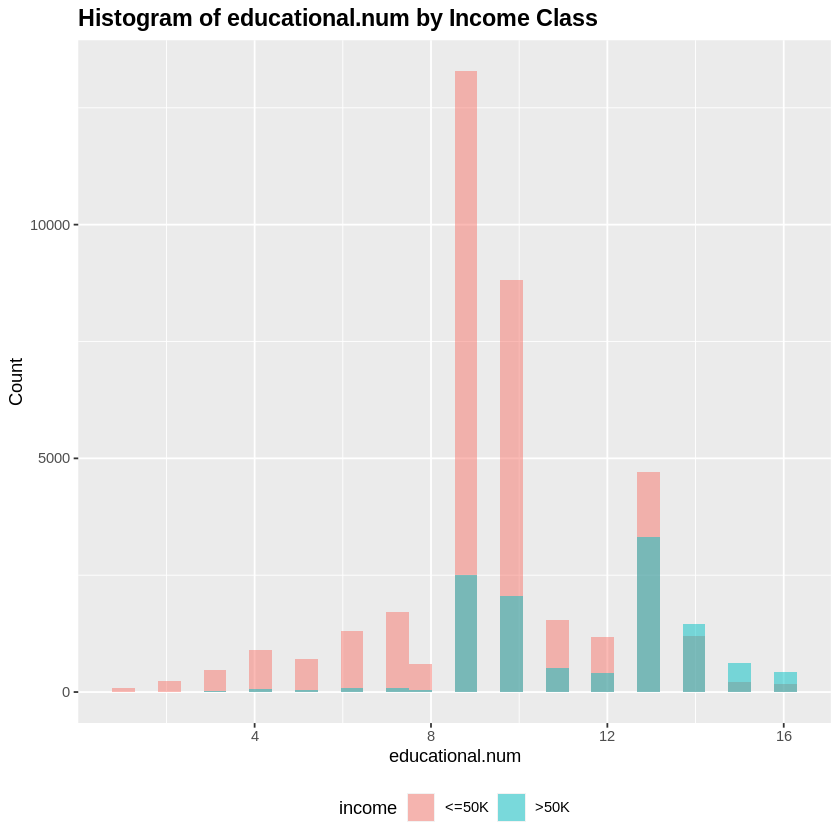

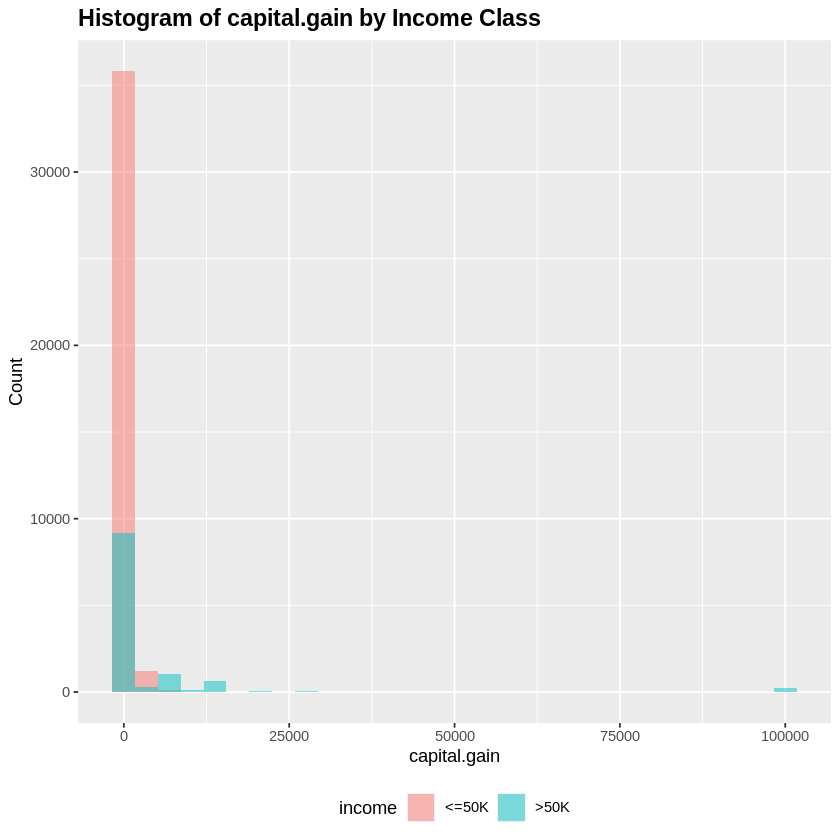

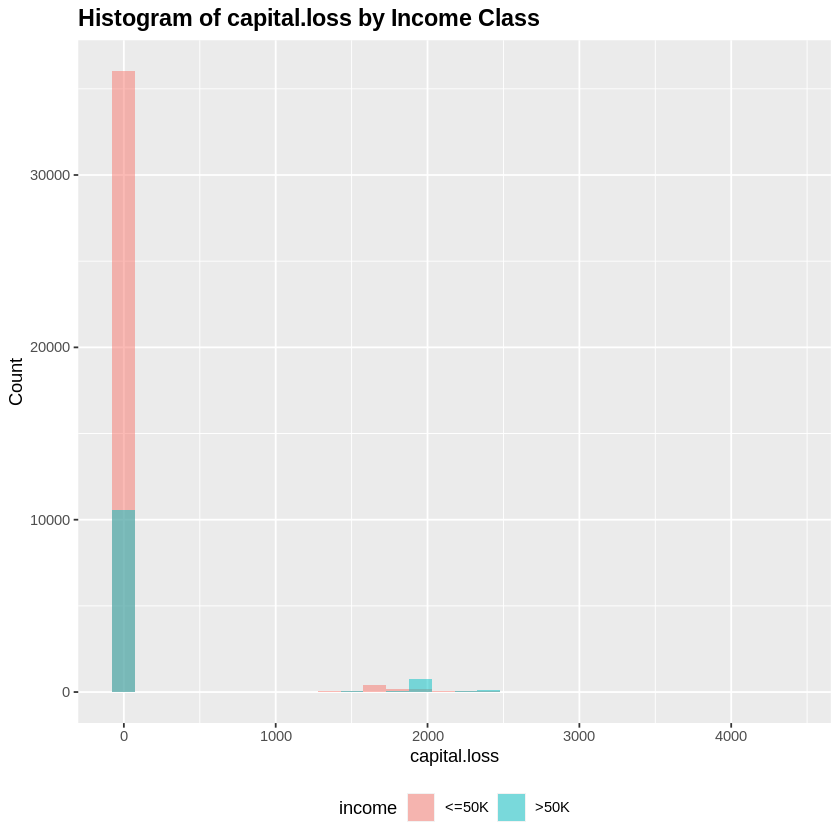

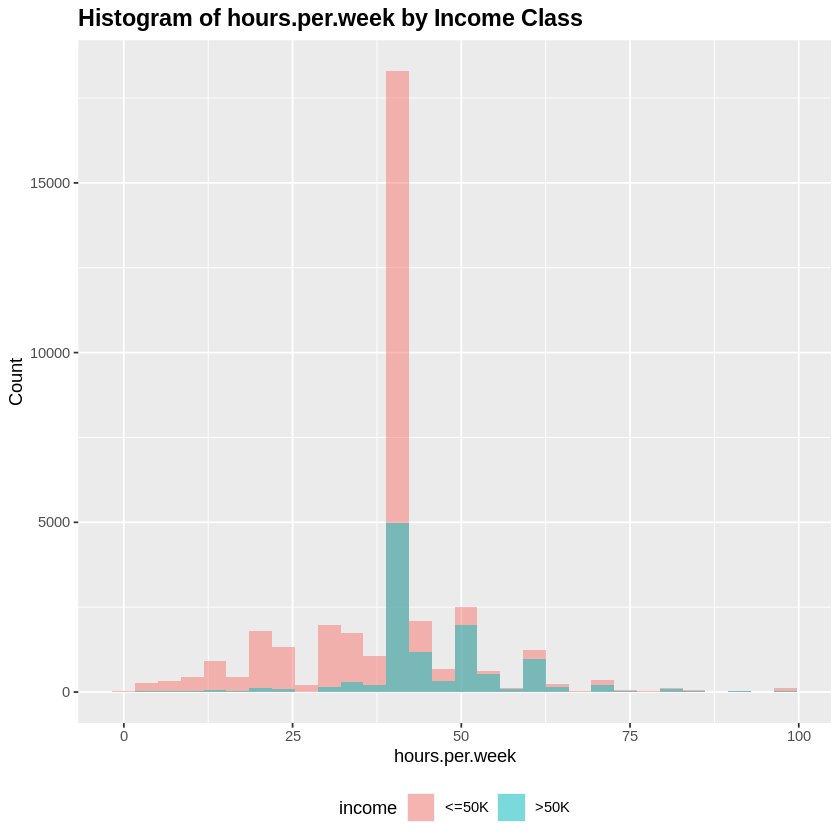

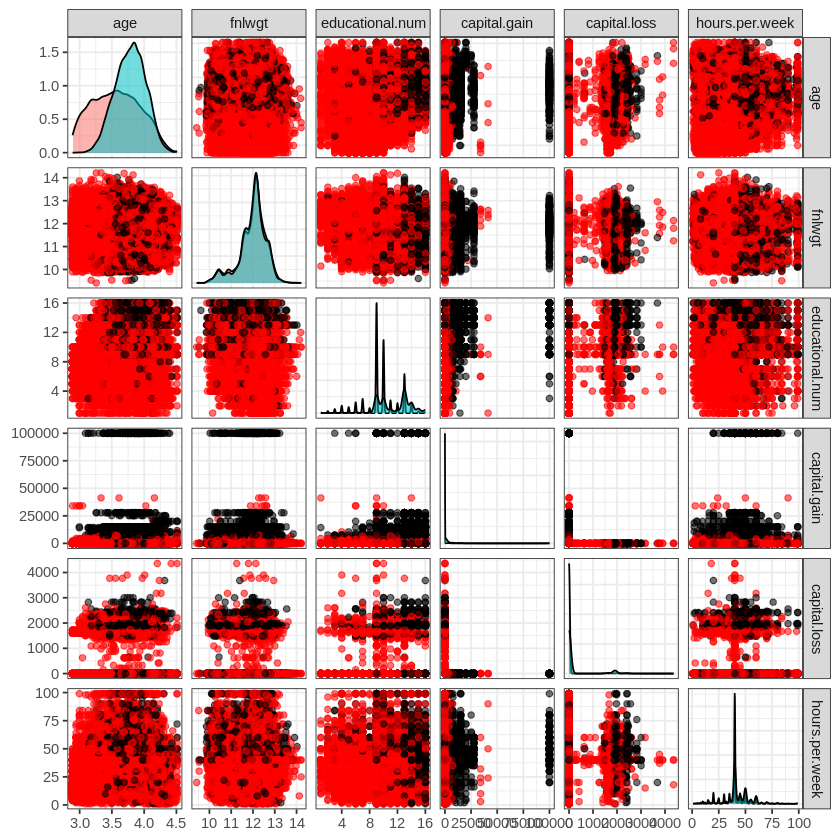

In [ ]:
# Visualize the original distribution of the 'age' and 'fnlwgt' variables. We see that both are right-skewed (greater concentration on the left side of the distribution).

p1 <- ggplot(data, aes(x = age)) + geom_histogram(binwidth = 1, fill = "skyblue", color = "black") + ggtitle("Age Distribution")
p2 <- ggplot(data, aes(x = fnlwgt)) + geom_histogram(binwidth = 50000, fill = "skyblue", color = "black") + ggtitle("Fnlwgt Distribution")
grid.arrange(p1, p2, ncol = 2)

# Apply the log() transformation to these variables because the Naive Bayes classifier assumes a multivariate normal distribution for numerical inputs.
# By applying the logarithmic transformation to 'age' and 'fnlwgt' using log1p() (to handle zeros and avoid possible negative values in the logarithm), we make
# both distributions closer to normal, slightly improving the classifier's performance.

data <- data %>%
  mutate(age = log1p(age),
         fnlwgt = log1p(fnlwgt))

# Visualize the transformed distribution of the numerical variables. We see that now both histograms are closer to normal.

p1 <- ggplot(data, aes(x = age)) + geom_histogram(binwidth = 0.1, fill = "skyblue", color = "black") + ggtitle("Log Age Distribution")
p2 <- ggplot(data, aes(x = fnlwgt)) + geom_histogram(binwidth = 0.1, fill = "skyblue", color = "black") + ggtitle("Log Fnlwgt Distribution")

# Create histograms for the rest of the numerical variables. In this case, we see that it is not necessary to apply the log() transformation since they have a more or less normal (and acceptable) behavior.

p3 <- ggplot(data, aes(x = educational.num)) + geom_histogram(binwidth = 1, fill = "skyblue", color = "black") + ggtitle("Educational Num Distribution")
p4 <- ggplot(data, aes(x = capital.gain)) + geom_histogram(binwidth = 1000, fill = "skyblue", color = "black") + ggtitle("Capital Gain Distribution")
p5 <- ggplot(data, aes(x = capital.loss)) + geom_histogram(binwidth = 100, fill = "skyblue", color = "black") + ggtitle("Capital Loss Distribution")
p6 <- ggplot(data, aes(x = hours.per.week)) + geom_histogram(binwidth = 5, fill = "skyblue", color = "black") + ggtitle("Hours per Week Distribution")
grid.arrange(p1, p2, p3, p4, p5, p6, ncol = 2)

# Explore the relationships between inputs and the target variable to decide if a classifier makes sense.

# Define a function to visualize the distribution of a variable by income class
plot_distribution <- function(data, variable, target) {
  ggplot(data, aes_string(x = variable, fill = target)) +
    geom_bar(position = "fill") +
    ggtitle(paste("Distribution of", variable, "by Income Class")) +
    theme(axis.text.x = element_text(angle = 90, hjust = 1, size = 12),
          plot.title = element_text(size = 14, face = "bold"),
          legend.position = "bottom") +
    labs(x = variable, y = "Proportion")
}

# Next, perform some simple visualizations to see the relationships between categorical input variables and the output.
# Define the categorical variables.
categorical_vars <- c("workclass", "education", "marital.status", "occupation", "relationship", "race", "gender", "native.country")

# Generate plots for each categorical variable
for (var in categorical_vars) {
  plot <- plot_distribution(data, var, "income")
  print(plot)
}

# We can do the same with numerical variables (inputs): histograms segmented by income class (output).

plot_histogram <- function(data, variable, target) {
  ggplot(data, aes_string(x = variable, fill = target)) +
    geom_histogram(position = "identity", alpha = 0.5, bins = 30) +
    ggtitle(paste("Histogram of", variable, "by Income Class")) +
    theme(plot.title = element_text(size = 14, face = "bold"),
          legend.position = "bottom") +
    labs(x = variable, y = "Count")
}

# Define the numerical variables.
numerical_vars <- c("age", "fnlwgt", "educational.num", "capital.gain", "capital.loss", "hours.per.week")

# Generate plots for each numerical variable
for (var in numerical_vars) {
  plot <- plot_histogram(data, var, "income")
  print(plot)
}

# Finally, for each numerical variable (input), we can generate a scatterplot matrix colored by income class (output).
# In this way, if there is a distinction between the two groups in the graph, represented by the colors red and black,
# the Naive Bayes classifier algorithm can work correctly. We observe that in general, this distinction is appreciated.

ggpairs(data, columns = c("age", "fnlwgt", "educational.num", "capital.gain", "capital.loss", "hours.per.week"),
        aes(color = income, alpha = 0.5),
        upper = list(continuous = "points"),
        lower = list(continuous = "points")) +
  scale_color_manual(values = c("<=50K" = "red", ">50K" = "black")) +
  theme_bw()

## 2. Generate training and test data

In [ ]:
# After the previous analysis and preprocessing, we can start by defining the model
# Set seed for reproducibility
set.seed(123)

# Split the dataset into training (70%) and test (30%) sets
trainIndex <- createDataPartition(data$income, p = 0.7, list = FALSE, times = 1)
data_train <- data[trainIndex, ]
data_test <- data[-trainIndex, ]

# Check the dimensions of the sets
dim(data_train)
dim(data_test)

# Check the proportion of the target variable in both sets
prop.table(table(data_train$income))
prop.table(table(data_test$income))

[1] 34190    15

[1] 14652    15


    <=50K      >50K 
0.7607195 0.2392805 


    <=50K      >50K 
0.7607153 0.2392847 

## 3. Generate the classifier and train the model

In [ ]:
# Train the Naive Bayes model
model_nb <- naiveBayes(income ~ ., data = data_train) # The output is income and the rest are inputs

# Model summary
print(model_nb)

# The output provides the prior probabilities of belonging to each of the two groups ("<=50K" or ">50K").
# Then we have the posterior probabilities for the quantitative inputs. As mentioned, Naive Bayes assumes that the distribution
# is multivariate normal for all inputs simultaneously. For example, it gives us the mean: 3.566423 and standard deviation: 0.3631589 for 'age' (for the <=50K group).
# And it does the same for the rest (we have a univariate normal distribution for each one). How are these parameters estimated? By likelihood, that is, it looks at the sample mean and
# standard deviation of the data associated with this output value. This is repeated for each numerical input. For categorical inputs, it doesn't give us the mean or standard deviation
# like before, but instead, for each value our input takes (for example, for the 'workclass' variable: 'Federal-gov', 'Local-gov', 'Never-worked', etc.),
# it gives the proportion of belonging to each of the input categories (parameters of the multinomial) for a fixed output. We can deduce that this will work relatively well
# as we have seen before, the data behaves more or less correctly.

# From here, predictions can be made. We can update our value that corresponds to the posterior distribution. This posterior distribution is applied
# to the test data, and we then have our predictions. We can obtain the posterior probability for each individual in the test set.


Naive Bayes Classifier for Discrete Predictors

Call:
naiveBayes.default(x = X, y = Y, laplace = laplace)

A-priori probabilities:
Y
    <=50K      >50K 
0.7607195 0.2392805 

Conditional probabilities:
       age
Y           [,1]      [,2]
  <=50K 3.566423 0.3631589
  >50K  3.784219 0.2348333

       workclass
Y        Federal-gov    Local-gov Never-worked      Private Self-emp-inc
  <=50K 0.0248114413 0.0637184190 0.0002885051 0.7665169188 0.0211845196
  >50K  0.0489361702 0.0801001252 0.0000000000 0.6481852315 0.0814768461
       workclass
Y       Self-emp-not-inc    State-gov  Without-pay
  <=50K     0.0809875118 0.0418744591 0.0006182253
  >50K      0.0961201502 0.0451814768 0.0000000000

       fnlwgt
Y           [,1]      [,2]
  <=50K 11.98434 0.6343153
  >50K  11.98111 0.6160479

       education
Y               10th         11th         12th      1st-4th      5th-6th
  <=50K 0.0344880618 0.0460994271 0.0162251528 0.0059210273 0.0131108462
  >50K  0.0075785356 0.0084341768 0.0

## 4. Make predictions with the model and validation

In [ ]:
# Make predictions on the test set
predictions_nb <- predict(model_nb, data_test)

# Create a comparison table of predictions and actual values, and print the first few values.
comparison <- data.frame(Actual = data_test$income, Prediction = predictions_nb)
head(comparison)

,Actual,Prediction
,<chr>,<fct>
1,>50K,<=50K
2,>50K,>50K
3,>50K,>50K
4,>50K,>50K
5,>50K,>50K
6,>50K,>50K


In [ ]:
# Calculate the confusion matrix
# Ensure that both predictions and actual values are factors with the same levels
predictions_nb <- factor(predictions_nb, levels = c("<=50K", ">50K"))
data_test$income <- factor(data_test$income, levels = c("<=50K", ">50K"))

# Generate the confusion matrix and obtain relevant statistics
confusion_matrix <- confusionMatrix(predictions_nb, data_test$income)
print(confusion_matrix)

# Specifically show the model's accuracy
accuracy <- confusion_matrix$overall['Accuracy']
print(paste("Model Accuracy: ", round(accuracy, 4)))

## COMMENTS ON THE RESULTS:

# Our Naive Bayes model shows a relatively high accuracy of 83%, with excellent sensitivity of 93%, suggesting it is very good at correctly identifying
# cases of income <=50K. However, the specificity is moderate (50.71%), indicating that the model has more difficulty correctly identifying
# cases of income >50K. The PPV and NPV metrics also reflect good overall performance, although there is room for improving specificity.
# All in all, considering how extremely simple the model is (based on such simple concepts as mean, standard deviation, proportions, etc.)
# and hence we call it -Naive-, we can say it is quite effective. It could be improved by adding greater complexity (through its generalization), such as
# including a Dirichlet distribution for weights, a distribution for the theta parameters, etc.; or by using more complex classification algorithms
# like Random Forest.

Confusion Matrix and Statistics

          Reference
Prediction <=50K  >50K
     <=50K 10369  1728
     >50K    777  1778
                                          
               Accuracy : 0.829           
                 95% CI : (0.8228, 0.8351)
    No Information Rate : 0.7607          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.4823          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.9303          
            Specificity : 0.5071          
         Pos Pred Value : 0.8572          
         Neg Pred Value : 0.6959          
             Prevalence : 0.7607          
         Detection Rate : 0.7077          
   Detection Prevalence : 0.8256          
      Balanced Accuracy : 0.7187          
                                          
       'Positive' Class : <=50K           
                  

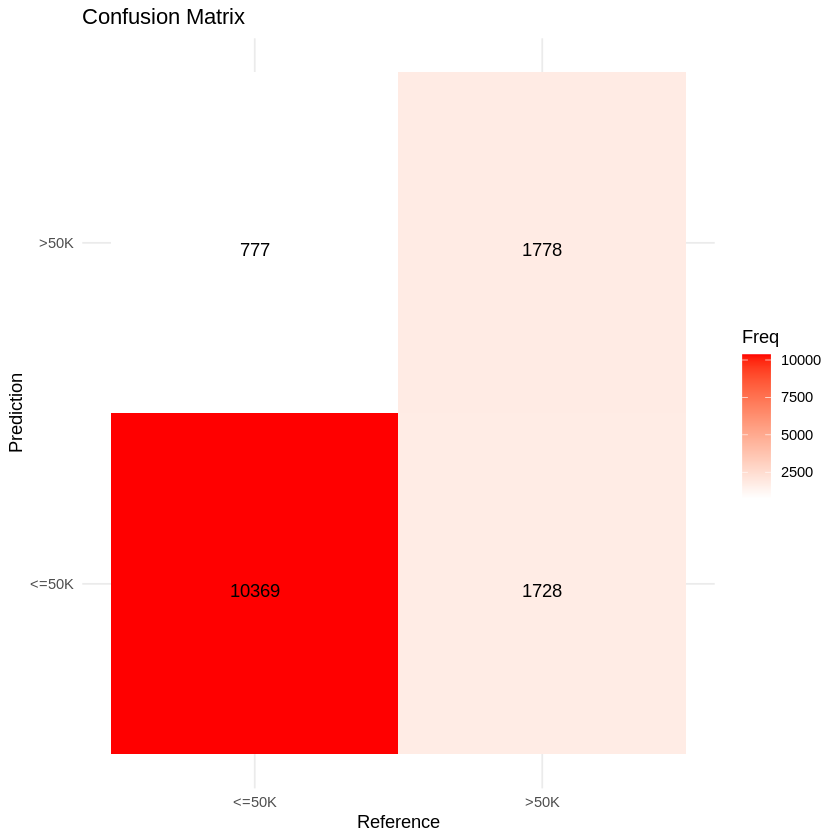

In [ ]:
# Fancy visualization of the confusion matrix

# Convert the confusion matrix to a data frame for ggplot
confusion_matrix_df <- as.data.frame(confusion_matrix$table)

ggplot(confusion_matrix_df, aes(x = Reference, y = Prediction, fill = Freq)) +
  geom_tile() +
  geom_text(aes(label = Freq), vjust = 1) +
  scale_fill_gradient(low = "white", high = "red") +
  ggtitle("Confusion Matrix") +
  theme_minimal()

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var


Setting levels: control = 0, case = 1

Setting direction: controls < cases



Area under the curve: 0.8691

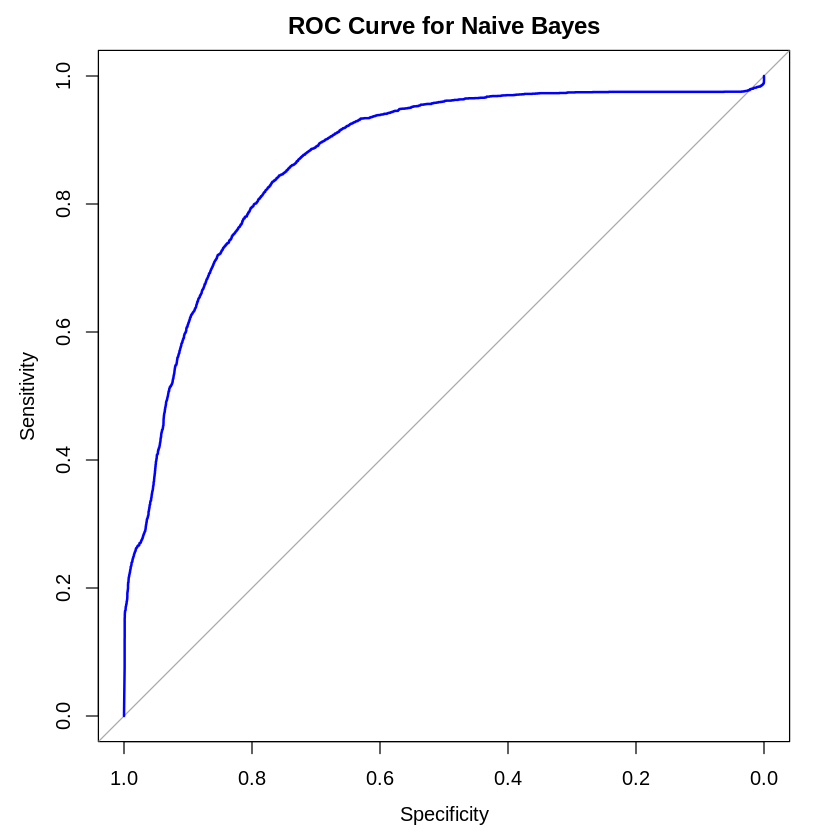

In [ ]:
# Other relevant visualizations (ROC curve) to measure model fit
install.packages("pROC")
library(pROC)

# Predict probabilities on the test set
pred_prob <- predict(model_nb, data_test, type = "raw")

# Convert the income variable to numeric for pROC
data_test$income_numeric <- ifelse(data_test$income == ">50K", 1, 0)

# Calculate the ROC curve
roc_curve <- roc(data_test$income_numeric, pred_prob[,2])

# Plot the ROC curve
plot(roc_curve, col = "blue", main = "ROC Curve for Naive Bayes")
auc(roc_curve)

# The ROC curve and the AUC value are useful tools for evaluating the performance of a classification model, in this case, our Naive Bayes model.
# Firstly, the ROC curve shows the relationship between the true positive rate (sensitivity) and the false positive rate (1 - specificity)
# across different decision thresholds. A curve that approaches the top-left corner indicates better model performance.
# The gray diagonal line, running from the bottom-left corner to the top-right corner, represents the performance of a random classifier, with an AUC of 0.5.
# The AUC (Area Under the ROC Curve) obtained for our Naive Bayes model is approximately 0.869, which indicates it has a good ability to distinguish
# between the two income classes (<=50K and >50K).
# Overall, these elements indicate that our algorithm is quite effective in income classification (of course, there's always room for improvement).
# As mentioned, the model's specificity can be improved, as it is relatively moderate to low.